In [1]:
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
import util
from shap.maskers import Independent
from sklearn.utils import resample
from sklearn.decomposition import PCA
from shap.plots import colors
import shap
from matplotlib import pyplot as plt
from sklearn.utils import resample, shuffle
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, y, feature_names, n_features, n_samples = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)

In [3]:
try:
    with open('shapvalues.multiclassdiff.proba.pickle', 'rb') as f:
        shap_values = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

No cached shap values found


## Generate Explanations

In [4]:
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
proba_equal = diff_clf.predict_proba(X)

Now we generate SHAP values for the difference classifier:

In [5]:
%%time
background_data = X
masker = Independent(data=background_data, max_samples=100)
explainer = shap.Explainer(diff_clf.predict_proba, masker, feature_names=feature_names)
shap_values = explainer(X)
with open(f'shapvalues.multiclassdiff.proba.pickle', 'wb') as f:
    pickle.dump(shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4.18 s, sys: 81.9 ms, total: 4.26 s
Wall time: 4.43 s


## Analyze

Preparations:

In [6]:
indices = np.indices(y.shape).ravel()
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
is_pred_equal = binary_diff_clf.predict(X)
is_pred_diff = ~is_pred_equal

In [7]:
shap_values_equality = util.reduce_multiclass_proba_diff_shap_values(shap_values)
overall_importance = shap_values_equality.abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

In [8]:
pred = diff_clf.predict(X)
indices_pred_equal = np.argwhere(is_pred_equal).ravel()
if indices_pred_equal.shape[0] > 250:
    indices_pred_equal = resample(indices_pred_equal, replace=False, random_state=42, n_samples=250, stratify=pred[indices_pred_equal])
indices_pred_diff = np.argwhere(is_pred_diff).ravel()
if indices_pred_diff.shape[0] > 250:
    indices_pred_diff = resample(indices_pred_diff, replace=False, random_state=42, n_samples=250, stratify=pred[indices_pred_diff])
indices_sample = np.concatenate((indices_pred_equal, indices_pred_diff))

### Feature Importance

#### Bar Plots

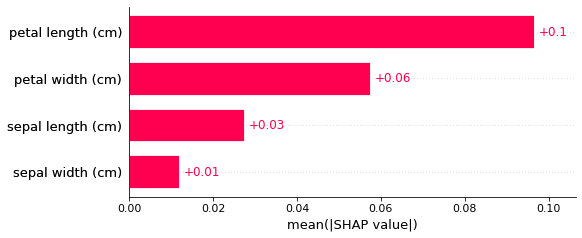

In [9]:
shap.plots.bar(overall_importance, max_display=n_features)

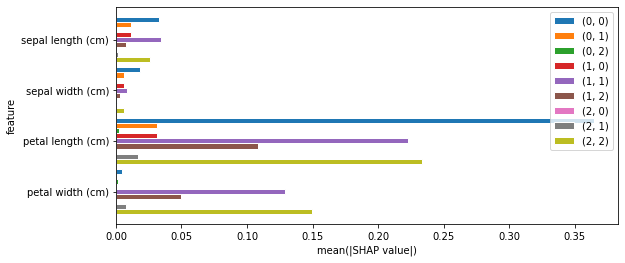

In [25]:
bar_width = 0.1
importances = shap_values.abs.mean(0).values.T
rects = [i * bar_width + np.arange(importances.shape[1]) for i in range(importances.shape[0])]
fig, ax = plt.subplots(figsize=(9, importances.shape[1]))
for class_idx, rect, importance in zip(diff_clf.classes_, rects, importances):
    ax.barh(rect, importance, height=bar_width, edgecolor='white', label=str(diff_clf.class_tuples[class_idx]))
ax.set_ylabel('feature')
ax.set_xlabel('mean(|SHAP value|)')
ax.set_yticks([r + bar_width * (len(diff_clf.classes_) - 1)/2 for r in range(importances.shape[1])])
ax.set_yticklabels(feature_names)
ax.invert_yaxis()
ax.legend()
plt.show()

#### SHAP Value Distribution

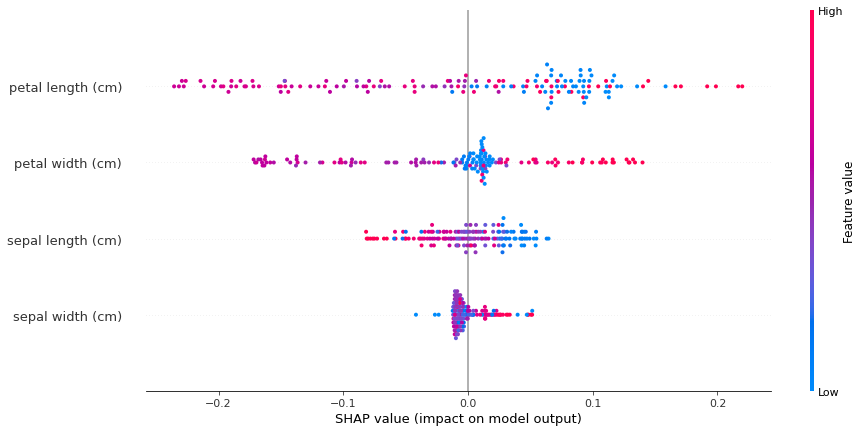

In [11]:
shap.plots.beeswarm(shap_values_equality, order=feature_order, plot_size=(14, 7))

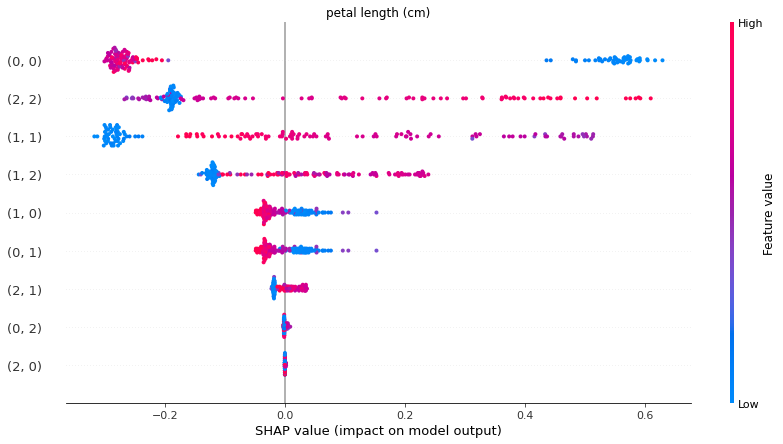

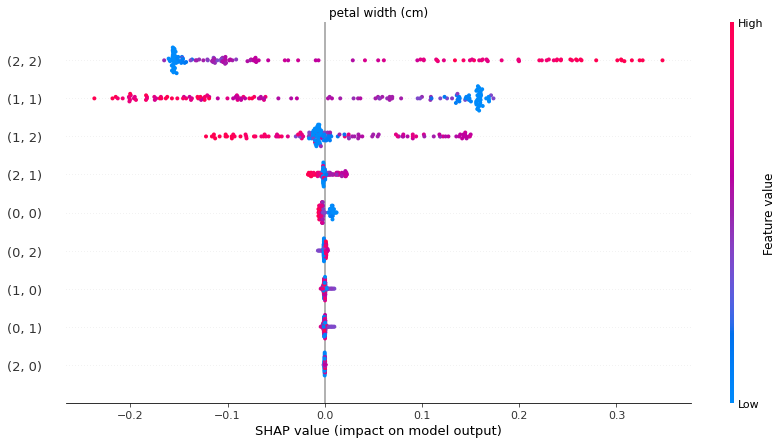

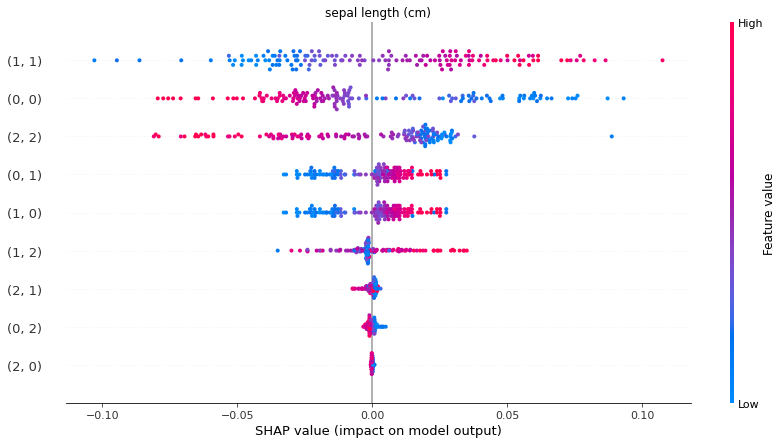

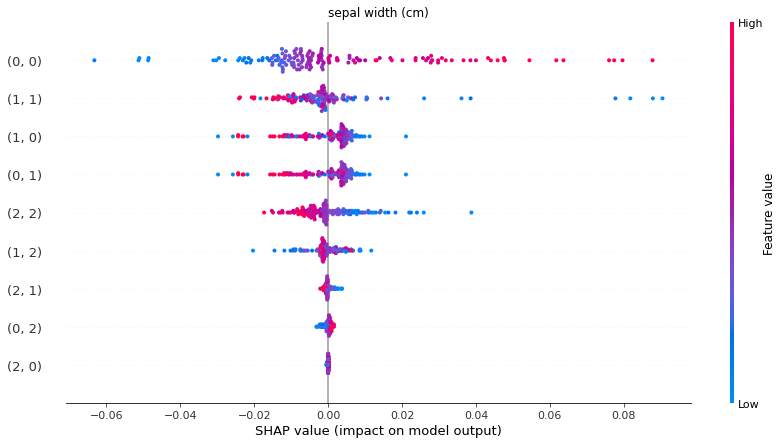

In [12]:
for feature_idx in feature_order:
    new_values = shap_values.values[:, feature_idx, :]
    new_data = np.reshape(np.repeat(shap_values.data[:, feature_idx], len(diff_clf.classes_)), (X.shape[0], len(diff_clf.classes_)))
    if shap_values.display_data is not None:
        new_display_data = np.reshape(np.repeat(shap_values.display_data[:, feature_idx], len(diff_clf.classes_)), (X.shape[0], len(diff_clf.classes_)))
    else:
        new_display_data = None
    new_base_values = shap_values.base_values
    class_names = [str(class_tuple) for class_tuple in diff_clf.class_tuples]
    shap_values_ = shap.Explanation(new_values, new_base_values, new_data, new_display_data, feature_names=class_names)
    shap.plots.beeswarm(shap_values_, plot_size=(14, 7), show=False)
    plt.title(feature_names[feature_idx])
    plt.show()

### Feature Effects

#### Partial Dependence Plots

Plot in blue are the instances where A and B predict the same label, plot over in red are instances where they differ.

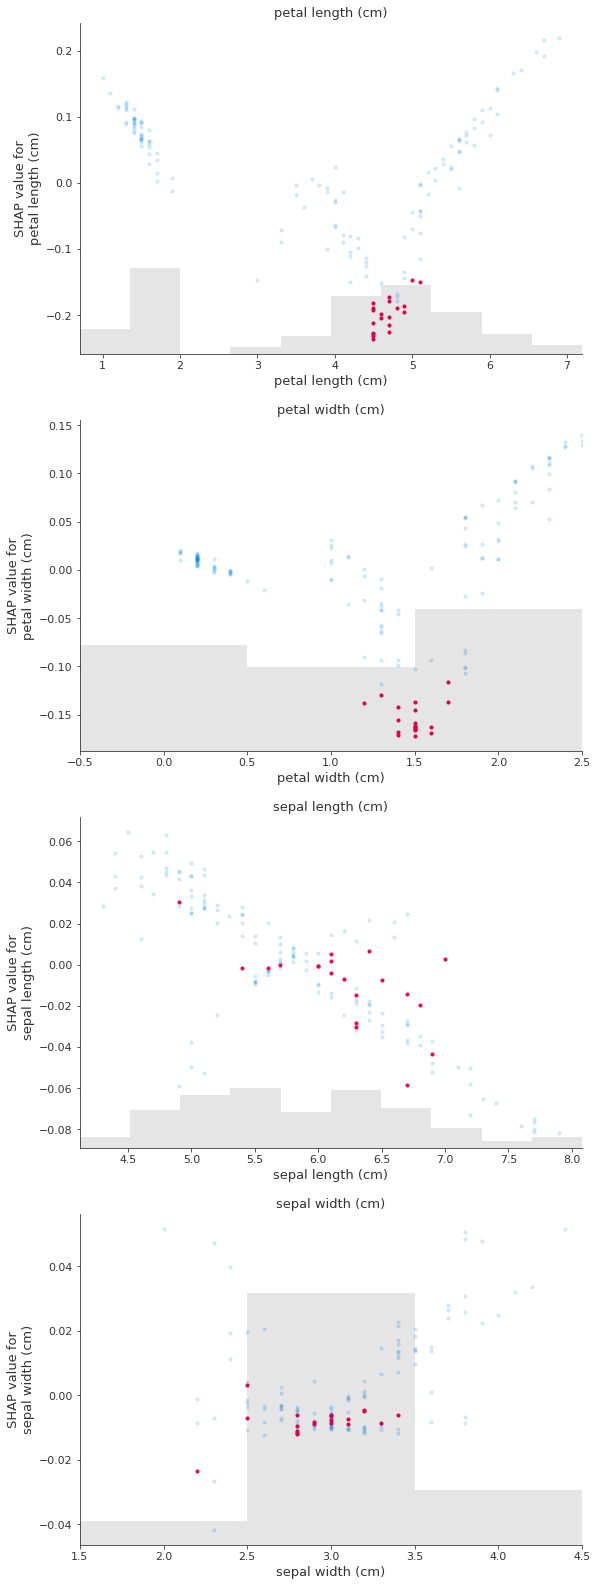

In [13]:
n_columns = 1
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax = fig.add_subplot(n_rows, n_columns, i)
    shap.plots.scatter(shap_values_equality[:, feature],
                       ax=ax,
                       color=tuple(colors.blue_rgb),
                       alpha=0.2,
                       show=False)
    shap.plots.scatter(shap_values_equality[is_pred_diff, feature],
                       title=feature,
                       ax=ax,
                       color=tuple(colors.red_rgb),
                       hist=False,
                       show=False)
    i += n_columns
plt.show()

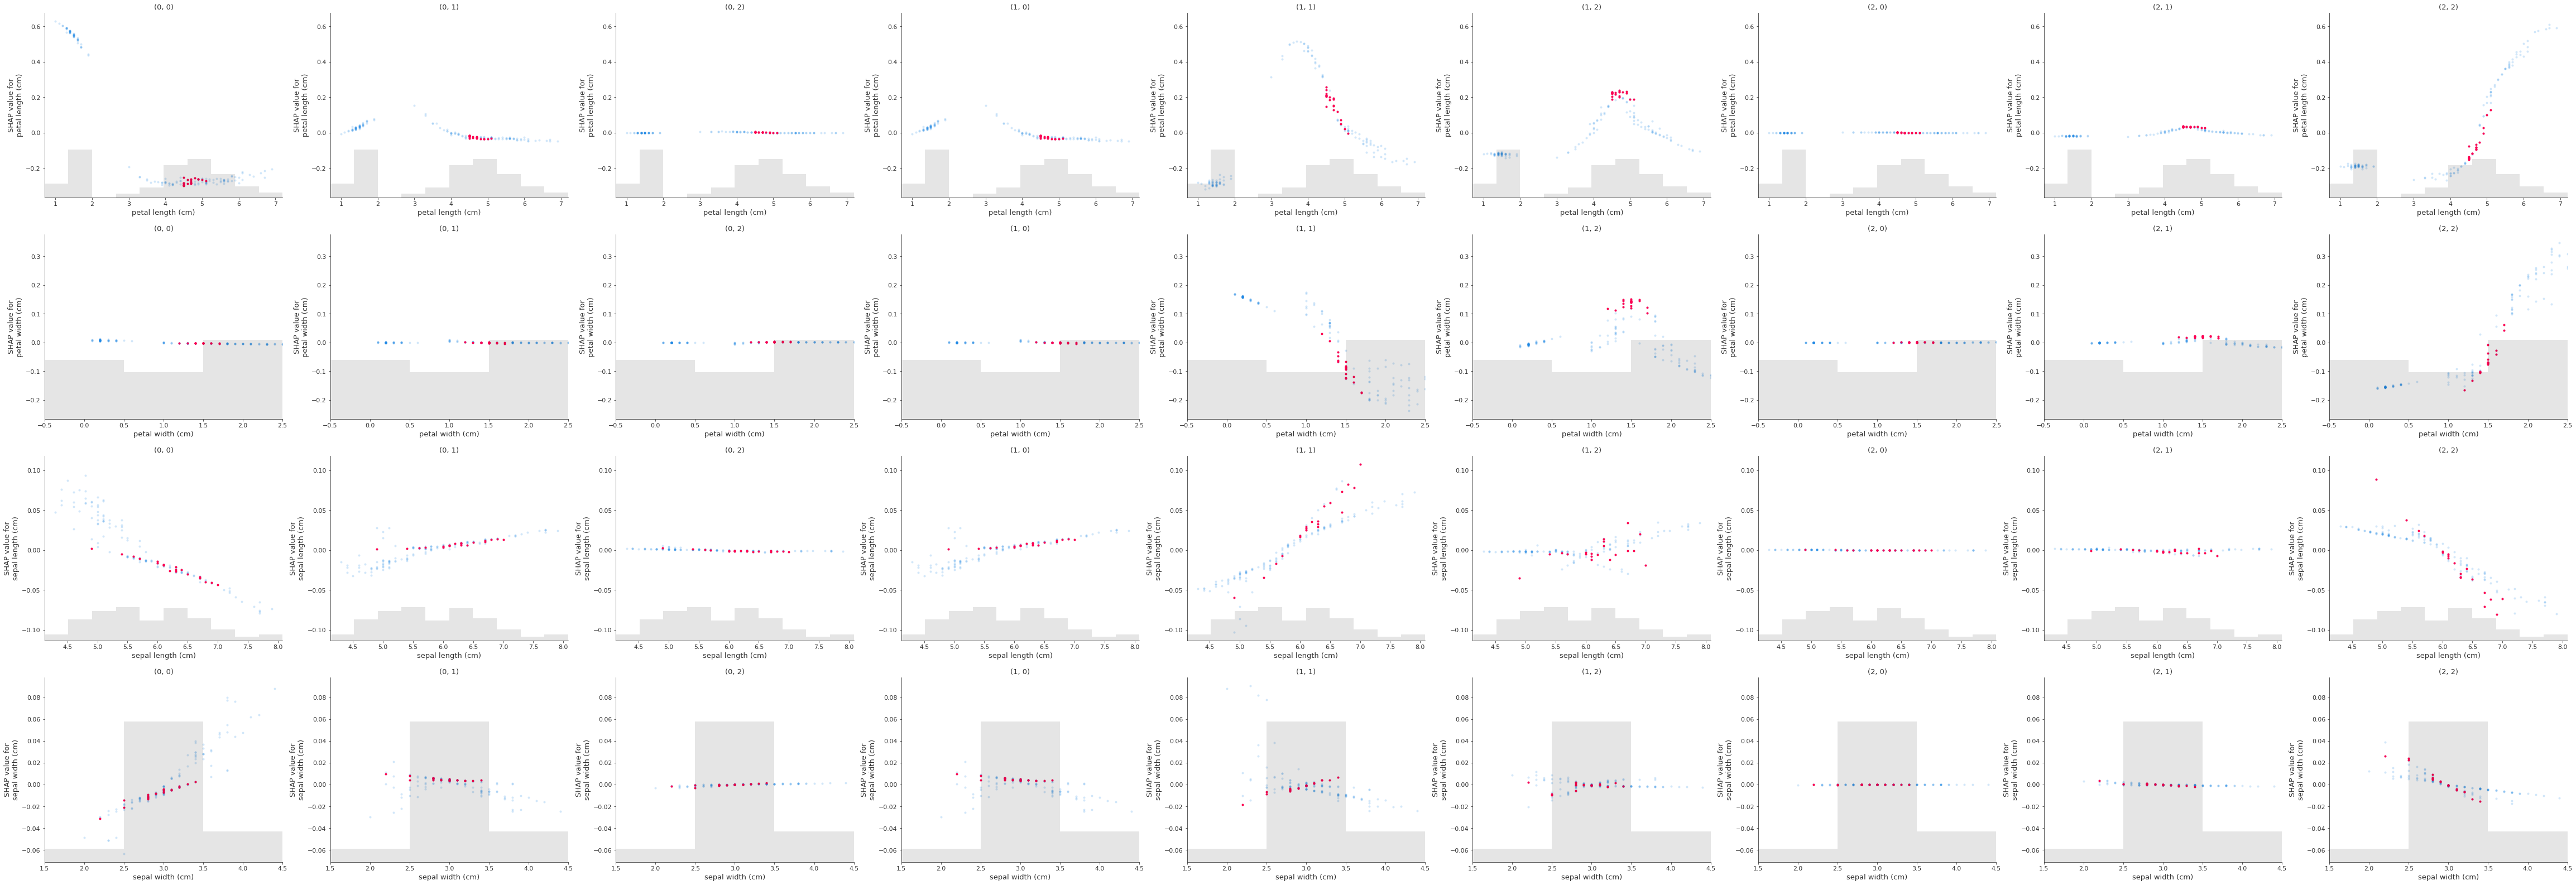

In [14]:
n_columns = len(diff_clf.classes_)
n_rows = n_features
fig = plt.figure(figsize=(9 * n_columns, 7 * n_rows))
plot_idx = 1
for feature in feature_names[feature_order]:
    ax_ref = None
    for class_idx, class_tuple in enumerate(diff_clf.class_tuples):
        ax = fig.add_subplot(n_rows, n_columns, plot_idx, sharey=ax_ref)
        if not ax_ref:
            ax_ref = ax
        shap.plots.scatter(shap_values[:, feature, class_idx],
                           ax=ax, alpha=0.2, show=False)
        shap.plots.scatter(shap_values[is_pred_diff, feature, class_idx],
                           ax=ax, title=str(class_tuple), 
                           color=tuple(colors.red_rgb),
                           hist=False, show=False)
        plot_idx += 1
plt.show()

### Cluster

#### Principal components
Visualize the first two principal components of the SHAP-values

In [15]:
pca = PCA(2)
embedding_values = pca.fit_transform(shap_values_equality.values)

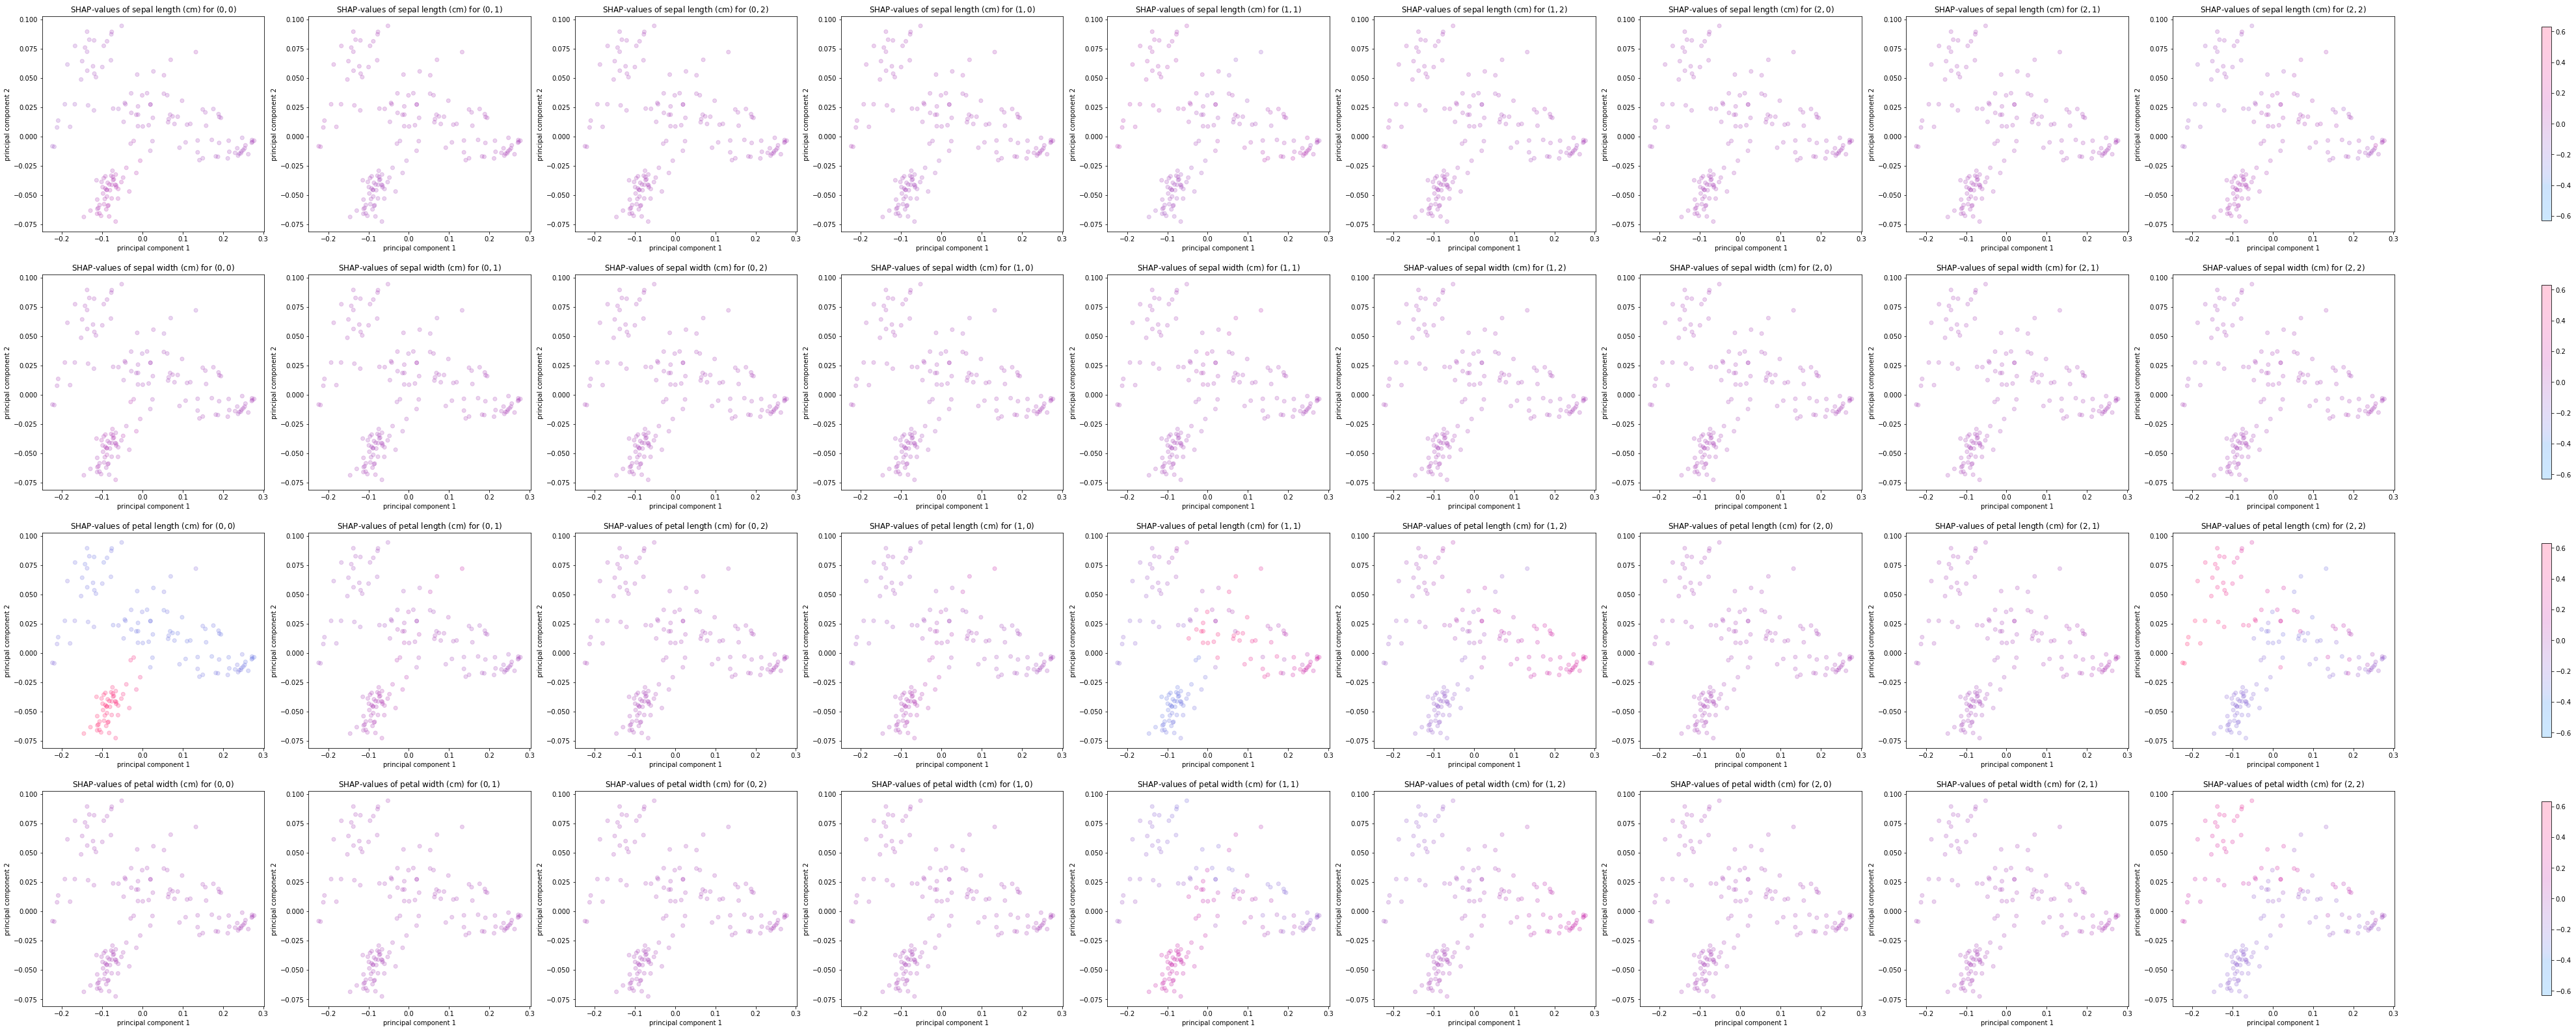

In [16]:
n_columns = len(diff_clf.classes_)
n_rows = n_features
fig, axs = plt.subplots(n_rows, n_columns, figsize=(9*n_columns, 7*n_rows))
plot_idx = 0
vmax = np.max(np.abs(shap_values.values[:, :]))
for feature_idx in range(n_features):
    for class_idx, class_tuple in enumerate(diff_clf.class_tuples):
        ax = axs.flat[plot_idx]
        cs = ax.scatter(embedding_values[:, 0],
                        embedding_values[:, 1],
                        c=shap_values.values[:, feature_idx, class_idx],
                        vmin=-vmax, vmax=vmax,
                        cmap=colors.red_blue,
                        alpha=0.2)
        ax.set_title(f'SHAP-values of {feature_names[feature_idx]} for ${class_tuple}$')
        ax.set_xlabel('principal component 1')
        ax.set_ylabel('principal component 2')
        plot_idx += 1
    fig.colorbar(cs, ax=axs[feature_idx].tolist(), shrink=0.9)
plt.show()

#### Force plots

In [17]:
shap_values_ = shap_values_equality[indices_sample]
data = shap_values_.display_data if shap_values_.display_data is not None else shap_values_.data
plot = shap.plots.force(
    base_value=shap_values_.base_values[0],
    shap_values=shap_values_.values,
    features=data,
    feature_names=feature_names)
instance_order = util.get_force_plot_ordering(plot)
display(plot)

In [18]:
for class_idx, class_tuple in enumerate(diff_clf.class_tuples):
    shap_values_ = shap_values[indices_sample, :, class_idx]
    data = shap_values_.display_data if shap_values_.display_data is not None else shap_values_.data
    plot = shap.plots.force(
        base_value=shap_values_.base_values[0],
        shap_values=shap_values_.values,
        features=data,
        feature_names=feature_names,
        out_names=str(class_tuple),
        ordering_keys=instance_order)
    display(plot)

#### Heatmaps

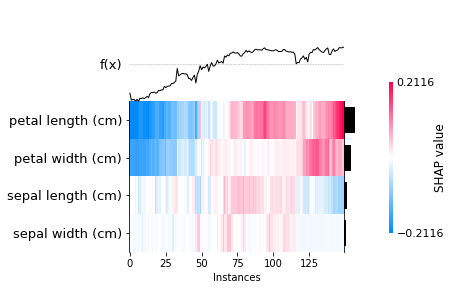

In [19]:
shap.plots.heatmap(shap_values_equality[indices_sample], max_display=n_features, feature_order=feature_order)

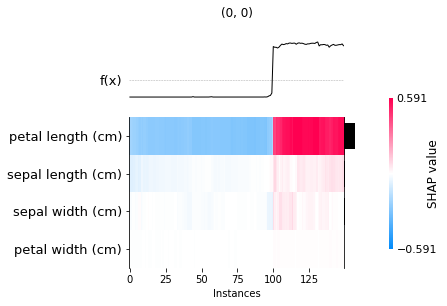

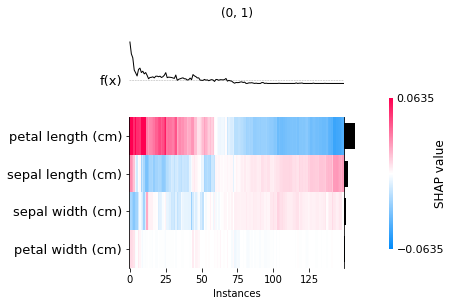

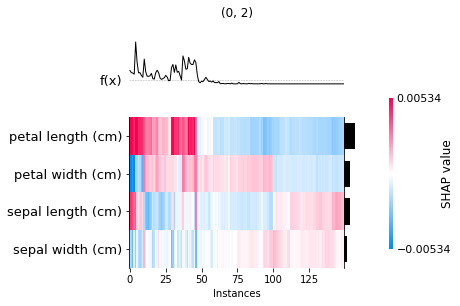

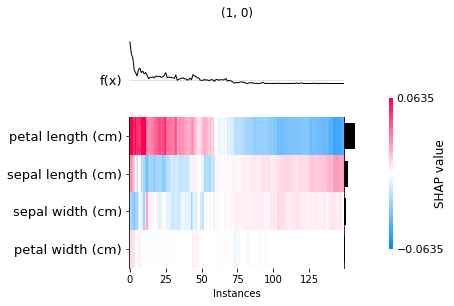

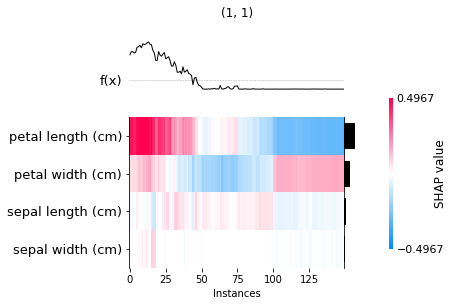

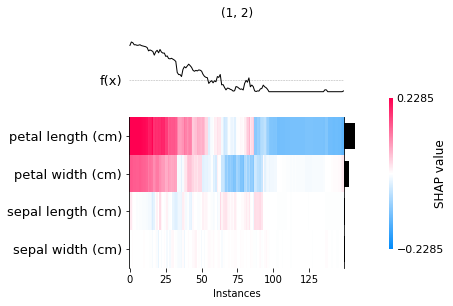

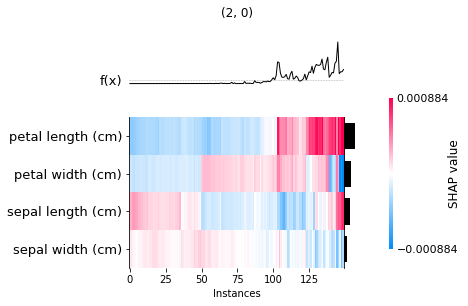

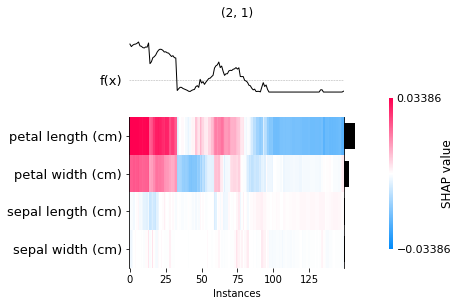

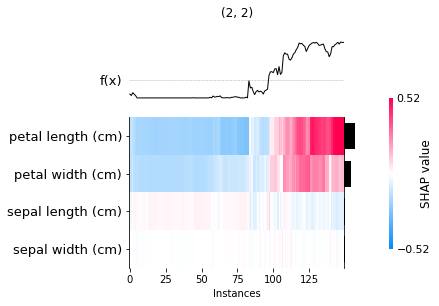

In [20]:
for class_idx, class_tuple in enumerate(diff_clf.class_tuples):
    shap_values_ = shap_values[indices_sample, :, class_idx]
    shap.plots.heatmap(shap_values_, max_display=n_features, show=False)
    plt.title(str(class_tuple))
    plt.show()

#### Decision plots

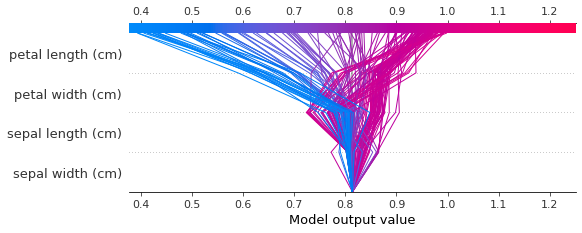

In [21]:
shap_values_ = shap_values_equality[indices_sample]
shap.plots.decision(shap_values_.base_values[0], shap_values_.values, feature_names=feature_names.tolist())

We can also visualize the individual shap values per difference class for a single instance, and we select the instance with the highest shap value

In [22]:
def class_labels(row_index):
    return [f'{diff_clf.class_tuples[i]} ({proba_equal[row_index, i].round(2):.2f})' for i in range(len(diff_clf.classes_))]

In [23]:
def plot_multioutput_decision(row_index):
    shap.multioutput_decision_plot(shap_values.base_values[0, :].tolist(),
                                   [a.T for a in list(shap_values.values.T)],
                                   row_index=row_index,
                                   feature_names=feature_names.tolist(), 
                                   highlight=[np.argmax(is_pred_equal[row_index])],
                                   legend_labels=class_labels(row_index),
                                   legend_location='lower right')

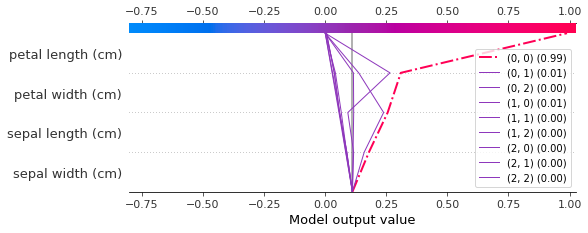

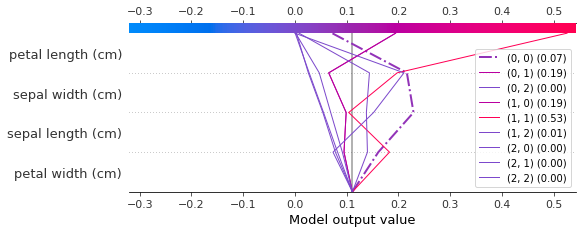

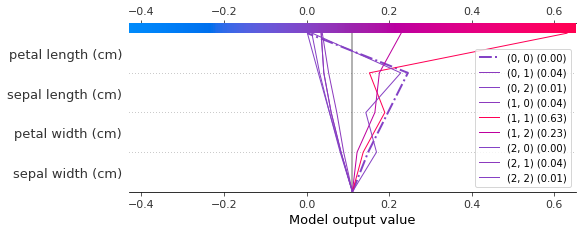

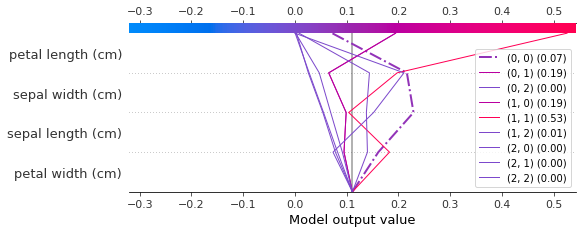

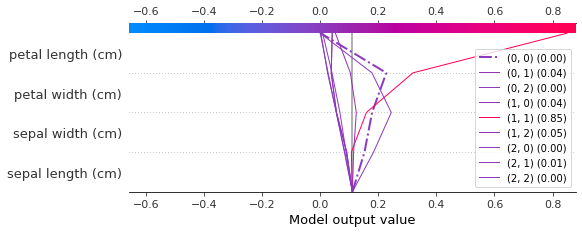

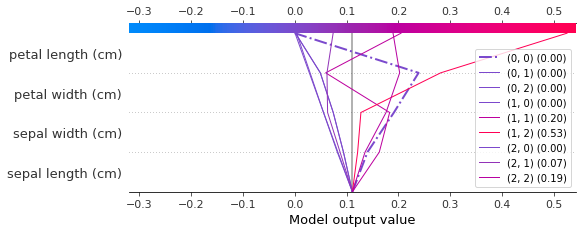

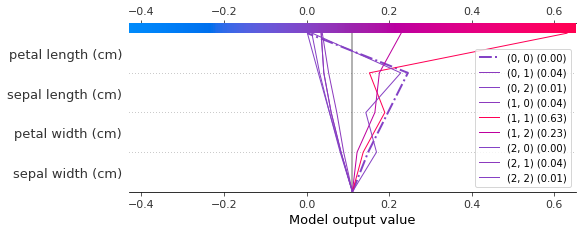

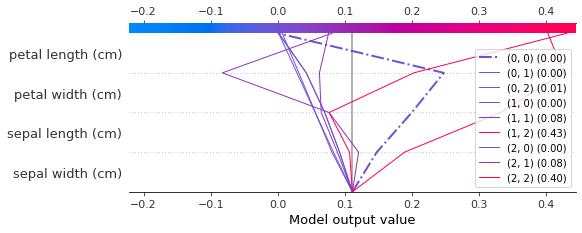

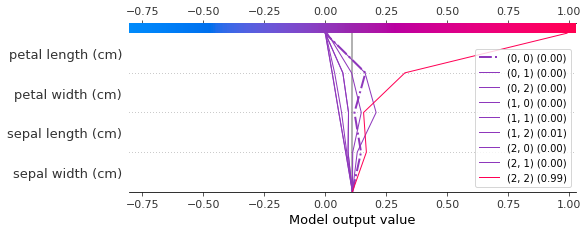

In [24]:
for class_idx in diff_clf.classes_:
    idx_max = np.argmax(np.max(shap_values.values[:, :, class_idx], axis=1))
    plot_multioutput_decision(idx_max)